# Comparison to Colossus

This notebook compares `halox` implementations against the [`colossus`](https://bdiemer.bitbucket.io/colossus/index.html) library to validate the accuracy of our calculations.
Each comparison illustrate how to use `halox` to compute properties that are also present in `colossus`, and shows the agreement between the two libraries and their relative differences.

**Note:** These comparison are implemented as unit tests in the GitHub repository; see [Tests workflow](https://github.com/fkeruzore/halox/actions/workflows/tests.yml).

In [45]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# halox imports
from halox import cosmology, nfw, hmf, lss, bias
from halox.halo import einasto

# colossus imports
from colossus.halo import profile_nfw, profile_einasto
from colossus.lss import mass_function, peaks, bias as colossus_bias
import colossus.cosmology.cosmology as cc

jax.config.update("jax_enable_x64", True)

plt.style.use(["seaborn-v0_8-darkgrid", "petroff10"])
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

We'll use a consistent cosmology for both libraries:

In [46]:
# Setup cosmologies for both libraries
# Primary cosmology: Planck18
cosmo_halox_planck = cosmology.Planck18()
cc.addCosmology(  # not taking base planck18 because it differs sightly
    "my_planck18",
    params={
        "flat": True,
        "H0": 100 * cosmo_halox_planck.h,
        "Om0": cosmo_halox_planck.Omega_m,
        "Ob0": cosmo_halox_planck.Omega_b,
        "sigma8": cosmo_halox_planck.sigma8,
        "ns": cosmo_halox_planck.n_s,
    },
)
cosmo_colossus_planck = "my_planck18"

# Alternative cosmology: Flamingo's LS8
cosmo_halox_alt = cosmology.Planck18(
    h=0.682,
    Omega_c=0.305 - 0.0473,
    Omega_b=0.0473,
    sigma8=0.76,
    n_s=0.965,
)

cc.setCosmology(cosmo_colossus_planck)
cc.addCosmology(
    "low_s8",
    params={
        "flat": True,
        "H0": 100 * cosmo_halox_alt.h,
        "Om0": cosmo_halox_alt.Omega_m,
        "Ob0": cosmo_halox_alt.Omega_b,
        "sigma8": cosmo_halox_alt.sigma8,
        "ns": cosmo_halox_alt.n_s,
    },
)
cosmo_colossus_alt = "low_s8"

In [47]:
def create_comparison_plot():
    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.05)
    ax_main = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)

    # Remove x-axis labels from main panel
    ax_main.tick_params(labelbottom=False)

    # Style both panels
    for ax in [ax_main, ax_ratio]:
        ax.xaxis.set_ticks_position("both")
        ax.yaxis.set_ticks_position("both")
        ax.grid(True, alpha=1.0)

    return fig, ax_main, ax_ratio


style_kw = [
    dict(color="C1", ls="-", lw=1.5, zorder=1),
    dict(color="C0", ls="--", lw=2.5, zorder=2),
    dict(color="C3", ls="-", lw=1.5, zorder=1),
    dict(color="C2", ls="--", lw=2.5, zorder=2),
    dict(color="C5", ls="-", lw=1.5, zorder=1),
    dict(color="C4", ls=":", lw=2.5, zorder=2),
    dict(color="C0", ls="-", lw=2.5, zorder=2),
    dict(color="C2", ls="-", lw=2.5, zorder=2),
    dict(color="C4", ls=":", lw=2.5, zorder=2),
]

## NFW Profile Comparisons

### NFW Density Profile

% diff at z=0:  [5.54956081e-10 5.46473977e-10 5.36259925e-10 5.23936450e-10
 5.09436937e-10 4.92339503e-10 4.72533124e-10 4.49884574e-10
 4.24504876e-10 3.96593869e-10 3.66395803e-10 3.34599015e-10
 3.01847436e-10 2.68940425e-10 2.36766162e-10 2.05857553e-10
 1.77036164e-10 1.50701673e-10 1.27076127e-10 1.06203935e-10
 8.81739126e-11 7.26751992e-11 5.96633853e-11 4.87387908e-11
 3.96571664e-11 3.21520588e-11 2.59792188e-11 2.10054196e-11
 1.68975944e-11 1.35891298e-11 1.09467990e-11 8.79296636e-12]
% diff at z=2:  [-0.04728879 -0.04589926 -0.04427361 -0.04239718 -0.04026469 -0.03788361
 -0.03527677 -0.03248359 -0.02955893 -0.02656963 -0.02358865 -0.02068817
 -0.01793276 -0.01537401 -0.01304761 -0.01097275 -0.00915376 -0.00758294
 -0.00624399 -0.00511531 -0.00417275 -0.00339178 -0.00274888 -0.00222247
 -0.00179332 -0.00144472 -0.00116237 -0.00093422 -0.00075021 -0.00060203
 -0.00048286 -0.0003871 ]


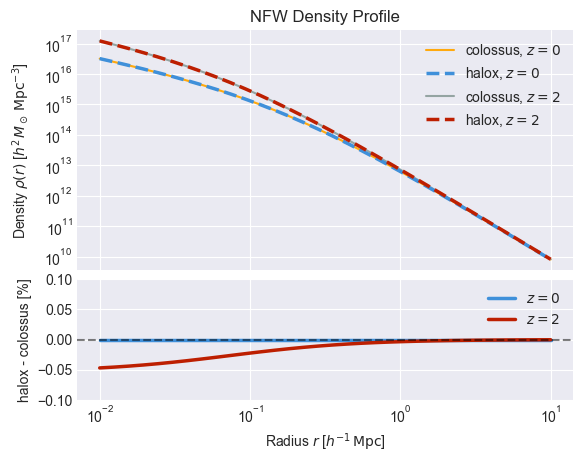

In [48]:
# Halo parameters
m_delta = 1e14  # h-1 Msun
c_delta = 5.0
deltas = [200.0]
redshifts = [0.0, 2.0]

# Radial range
r = jnp.logspace(-2, 1, 32)  # h-1 Mpc

# Compute density profiles for both redshifts
rho_halox = {}
rho_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    rho_halox[z] = nfw_halox.density(r)
    rho_colossus[z] = nfw_colossus.density(r * 1000) * 1e9

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, rho_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, rho_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(r, rho_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.loglog(r, rho_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax_main.set_title("NFW Density Profile")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (rho_halox[0.0] / rho_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (rho_halox[2.0] / rho_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

print("% diff at z=0: ", ratio_z0)
print("% diff at z=2: ", ratio_z1)

### NFW Enclosed Mass

% diff at z=0:  [5.70321568e-10 5.61417579e-10 5.52868862e-10 5.48272538e-10
 5.35860245e-10 5.25091082e-10 5.11080067e-10 4.95203878e-10
 4.77351492e-10 4.56990001e-10 4.35451675e-10 4.12048173e-10
 3.87512245e-10 3.62199160e-10 3.36730643e-10 3.11617399e-10
 2.87281310e-10 2.64077649e-10 2.42228460e-10 2.22044605e-10
 2.03548289e-10 1.86717308e-10 1.71462844e-10 1.57740487e-10
 1.45528034e-10 1.34536826e-10 1.24722455e-10 1.15951693e-10
 1.08113518e-10 1.01074704e-10 9.47686374e-11 8.90620910e-11]
% diff at z=2:  [-0.0494174  -0.04846782 -0.04735034 -0.04605117 -0.04456176 -0.04288102
 -0.04101732 -0.03898971 -0.03682789 -0.03457066 -0.03226294 -0.02995185
 -0.02768251 -0.02549441 -0.02341893 -0.02147827 -0.01968551 -0.01804577
 -0.01655774 -0.01521541 -0.01400967 -0.01292966 -0.01196376 -0.01110038
 -0.01032838 -0.00963741 -0.00901802 -0.00846173 -0.00796098 -0.00750913
 -0.00710036 -0.00672954]


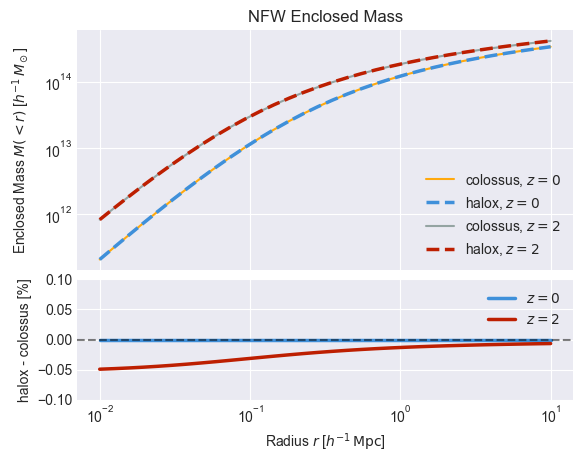

In [49]:
# Compute enclosed mass profiles for both redshifts
mass_halox = {}
mass_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    mass_halox[z] = nfw_halox.enclosed_mass(r)
    mass_colossus[z] = nfw_colossus.enclosedMass(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, mass_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, mass_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(r, mass_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.loglog(r, mass_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Enclosed Mass $M(<r)$ [$h^{-1} \, M_\odot$]")
ax_main.set_title("NFW Enclosed Mass")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (mass_halox[0.0] / mass_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (mass_halox[2.0] / mass_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

print("% diff at z=0: ", ratio_z0)
print("% diff at z=2: ", ratio_z1)

### NFW Surface Density

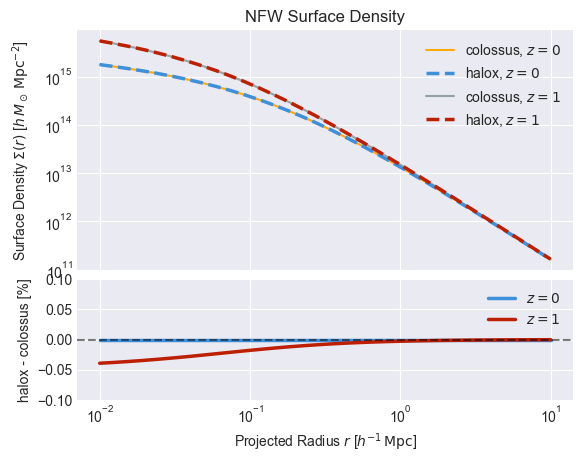

In [50]:
# Compute surface density profiles for both redshifts
sigma_surf_halox = {}
sigma_surf_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    sigma_surf_halox[z] = nfw_halox.surface_density(r)
    sigma_surf_colossus[z] = nfw_colossus.surfaceDensity(r * 1000) * 1e6

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(
    r, sigma_surf_colossus[0.0], label="colossus, $z=0$", **style_kw[0]
)
ax_main.loglog(r, sigma_surf_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(
    r, sigma_surf_colossus[2.0], label="colossus, $z=1$", **style_kw[2]
)
ax_main.loglog(r, sigma_surf_halox[2.0], label="halox, $z=1$", **style_kw[3])

ax_main.set_ylabel(
    r"Surface Density $\Sigma(r)$ [$h \, M_\odot \, {\rm Mpc}^{-2}$]"
)
ax_main.set_title("NFW Surface Density")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (
    sigma_surf_halox[0.0] / sigma_surf_colossus[0.0] - 1.0
) * 100  # Convert to %
ratio_z1 = (
    sigma_surf_halox[2.0] / sigma_surf_colossus[2.0] - 1.0
) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=1$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Projected Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### NFW Circular Velocity

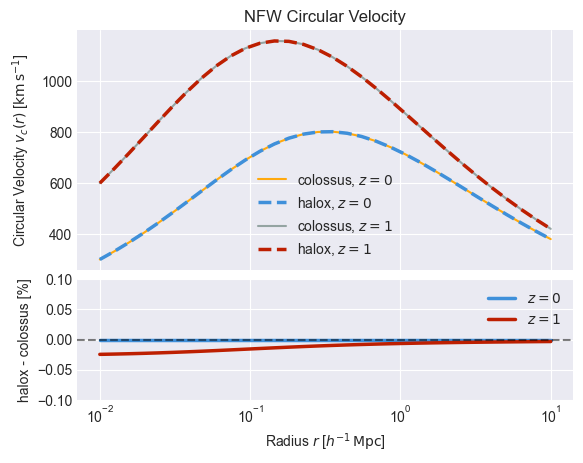

In [51]:
# Compute circular velocity profiles for both redshifts
v_c_halox = {}
v_c_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    v_c_halox[z] = nfw_halox.circular_velocity(r)
    v_c_colossus[z] = nfw_colossus.circularVelocity(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.semilogx(r, v_c_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.semilogx(r, v_c_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.semilogx(r, v_c_colossus[2.0], label="colossus, $z=1$", **style_kw[2])
ax_main.semilogx(r, v_c_halox[2.0], label="halox, $z=1$", **style_kw[3])

ax_main.set_ylabel(r"Circular Velocity $v_c(r)$ [${\rm km} \, {\rm s}^{-1}$]")
ax_main.set_title("NFW Circular Velocity")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (v_c_halox[0.0] / v_c_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (v_c_halox[2.0] / v_c_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=1$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

# Einasto Profile Comparison

### Einasto Density Profile

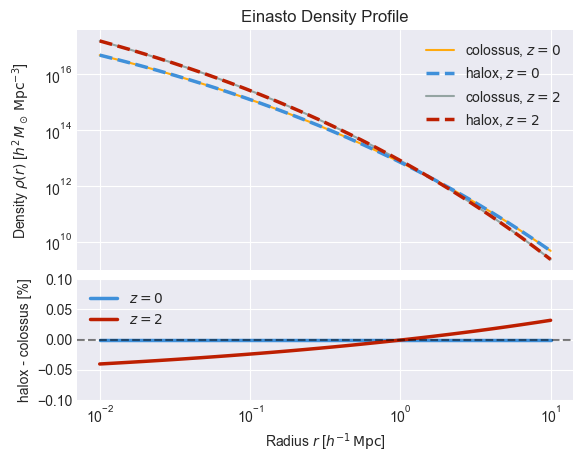

In [52]:
# Halo parameters
m_delta = 1e14  # h-1 Msun
c_delta = 5.0
alpha = 0.15
deltas = [200.0]
redshifts = [0.0, 2.0]

# Radial range
r = jnp.logspace(-2, 1, 32)  # h-1 Mpc

# Compute density profiles for both redshifts
rho_halox = {}
rho_colossus = {}

for z in redshifts:
    einasto_halox = einasto.EinastoHalo(
        m_delta, c_delta, alpha, z, cosmo_halox_planck, delta=deltas[0]
    )
    einasto_colossus = profile_einasto.EinastoProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c", alpha=alpha
    )

    rho_halox[z] = einasto_halox.density(r)
    rho_colossus[z] = einasto_colossus.density(r * 1000) * 1e9

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, rho_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, rho_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=1.0
ax_main.loglog(r, rho_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.loglog(r, rho_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax_main.set_title("Einasto Density Profile")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (rho_halox[0.0] / rho_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (rho_halox[2.0] / rho_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

# print("% diff at z=0: ", ratio_z0)
# print("% diff at z=2: ", ratio_z1)

### Einasto Enclosed Mass

% diff at z=0:  [5.24180699e-10 5.12279108e-10 4.99000841e-10 4.87299090e-10
 4.74287276e-10 4.60032012e-10 4.47397674e-10 4.33475478e-10
 4.19730917e-10 4.04787315e-10 3.90065757e-10 3.73745479e-10
 3.58335583e-10 3.41660034e-10 3.26316751e-10 3.09019477e-10
 2.92210700e-10 2.75557355e-10 2.58171262e-10 2.40563125e-10
 2.23310259e-10 2.05080397e-10 1.88538074e-10 1.71818115e-10
 1.54276592e-10 1.35202960e-10 1.19104726e-10 1.04005693e-10
 8.92397267e-11 7.58060281e-11 6.31494856e-11 5.15143483e-11]
% diff at z=2:  [-0.04393601 -0.04275677 -0.04154499 -0.04030049 -0.03902322 -0.03771326
 -0.03637085 -0.03499646 -0.03359078 -0.0321548  -0.03068982 -0.02919754
 -0.02768011 -0.02614017 -0.024581   -0.02300653 -0.02142144 -0.01983129
 -0.01824257 -0.01666275 -0.01510037 -0.01356503 -0.01206733 -0.01061875
 -0.00923141 -0.00791772 -0.00668988 -0.00555924 -0.00453561 -0.0036264
 -0.00283595 -0.00216493]


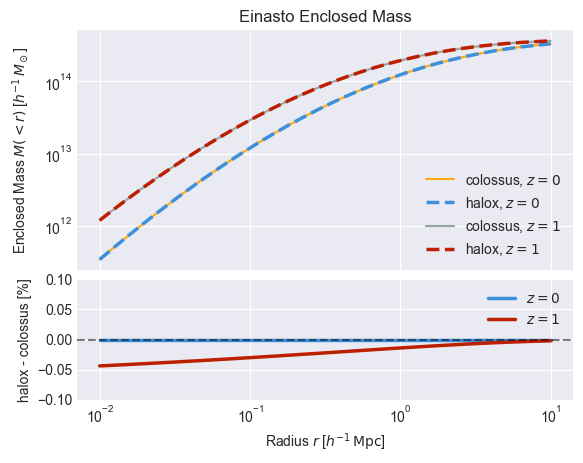

In [53]:
# Compute enclosed mass profiles for both redshifts
mass_halox = {}
mass_colossus = {}

for z in redshifts:
    einasto_halox = einasto.EinastoHalo(
        m_delta, c_delta, alpha, z, cosmo_halox_planck, delta=deltas[0]
    )
    einasto_colossus = profile_einasto.EinastoProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c", alpha=alpha
    )

    mass_halox[z] = einasto_halox.enclosed_mass(r)
    mass_colossus[z] = einasto_colossus.enclosedMass(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, mass_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, mass_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(r, mass_colossus[2.0], label="colossus, $z=1$", **style_kw[2])
ax_main.loglog(r, mass_halox[2.0], label="halox, $z=1$", **style_kw[3])

ax_main.set_ylabel(r"Enclosed Mass $M(<r)$ [$h^{-1} \, M_\odot$]")
ax_main.set_title("Einasto Enclosed Mass")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (mass_halox[0.0] / mass_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (mass_halox[2.0] / mass_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=1$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

print("% diff at z=0: ", ratio_z0)
print("% diff at z=2: ", ratio_z1)

### Einasto Circular Velocity

% diff at z=0:  [-1.79689597e-10 -1.85629290e-10 -1.92268423e-10 -1.98119299e-10
 -2.04625206e-10 -2.11730633e-10 -2.18070006e-10 -2.25031105e-10
 -2.31914488e-10 -2.39364084e-10 -2.46747067e-10 -2.54907206e-10
 -2.62612154e-10 -2.70961031e-10 -2.78610468e-10 -2.87270208e-10
 -2.95685698e-10 -3.03990166e-10 -3.12705417e-10 -3.21509486e-10
 -3.30124816e-10 -3.39239747e-10 -3.47522011e-10 -3.55848684e-10
 -3.64630548e-10 -3.74178466e-10 -3.82227583e-10 -3.89765997e-10
 -3.97137878e-10 -4.03888034e-10 -4.10182999e-10 -4.16011670e-10]
% diff at z=2:  [-0.02197042 -0.02138067 -0.02077465 -0.02015228 -0.01951352 -0.01885841
 -0.01818708 -0.01749976 -0.0167968  -0.01607869 -0.01534609 -0.01459984
 -0.01384101 -0.01307094 -0.01229126 -0.01150393 -0.0107113  -0.00991614
 -0.0091217  -0.00833172 -0.00755047 -0.00678275 -0.00603385 -0.00530952
 -0.00461581 -0.00395894 -0.00334499 -0.00277966 -0.00226783 -0.00181321
 -0.00141798 -0.00108247]


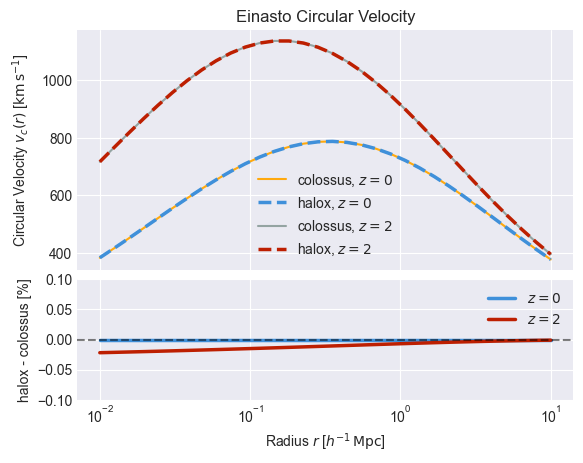

In [54]:
# Compute circular velocity profiles for both redshifts
v_c_halox = {}
v_c_colossus = {}

for z in redshifts:
    einasto_halox = einasto.EinastoHalo(
        m_delta, c_delta, alpha, z, cosmo_halox_planck, delta=deltas[0]
    )
    einasto_colossus = profile_einasto.EinastoProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c", alpha = alpha
    )

    v_c_halox[z] = einasto_halox.circular_velocity(r)
    v_c_colossus[z] = einasto_colossus.circularVelocity(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.semilogx(r, v_c_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.semilogx(r, v_c_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.semilogx(r, v_c_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.semilogx(r, v_c_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Circular Velocity $v_c(r)$ [${\rm km} \, {\rm s}^{-1}$]")
ax_main.set_title("Einasto Circular Velocity")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (v_c_halox[0.0] / v_c_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (v_c_halox[2.0] / v_c_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

print("% diff at z=0: ", ratio_z0)
print("% diff at z=2: ", ratio_z1)

### Einasto Potential

## LSS and Halo Mass Function Comparisons

### RMS Variance σ(R,z)

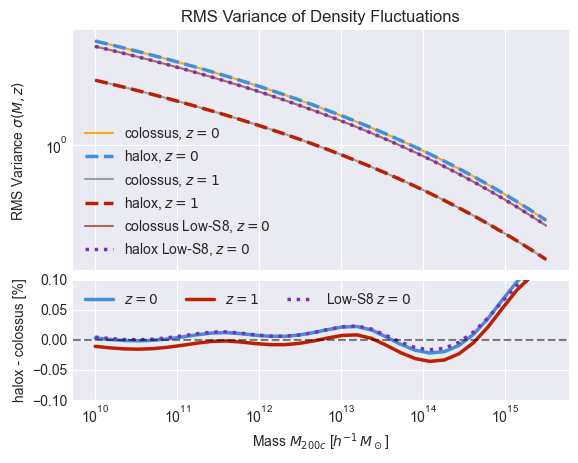

In [55]:
# Mass range and redshifts
masses = jnp.logspace(10, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]

# Compute sigma values for both redshifts and cosmologies
sigma_halox_planck = {}
sigma_halox_alt = {}
sigma_colossus_planck = {}
sigma_colossus_alt = {}


@jax.jit
def compute_sigma_halox(masses, z, cosmo):
    """JIT-compiled batch computation of sigma values"""
    R = lss.mass_to_lagrangian_radius(masses, cosmo)
    return lss.sigma_R(R, z, cosmo)


for z in redshifts:
    # Planck cosmology
    sigma_halox_planck[z] = compute_sigma_halox(masses, z, cosmo_halox_planck)
    cosmo_col_obj_planck = cc.setCosmology(cosmo_colossus_planck)
    sigma_colossus_planck[z] = cosmo_col_obj_planck.sigma(
        peaks.lagrangianR(masses), z=z
    )

    # Alternative cosmology
    sigma_halox_alt[z] = compute_sigma_halox(masses, z, cosmo_halox_alt)
    cosmo_col_obj_alt = cc.setCosmology(cosmo_colossus_alt)
    sigma_colossus_alt[z] = cosmo_col_obj_alt.sigma(
        peaks.lagrangianR(masses), z=z
    )

# Reset to Planck cosmology for subsequent cells
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses, sigma_colossus_planck[0.0], label="colossus, $z=0$", **style_kw[0]
)
ax_main.loglog(
    masses, sigma_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses, sigma_colossus_planck[1.0], label="colossus, $z=1$", **style_kw[2]
)
ax_main.loglog(
    masses, sigma_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    sigma_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, sigma_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(r"RMS Variance $\sigma(M,z)$")
ax_main.set_title("RMS Variance of Density Fluctuations")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    sigma_halox_planck[0.0] / sigma_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    sigma_halox_planck[1.0] / sigma_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (sigma_halox_alt[0.0] / sigma_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### Tinker08 Multiplicity Function f(σ)

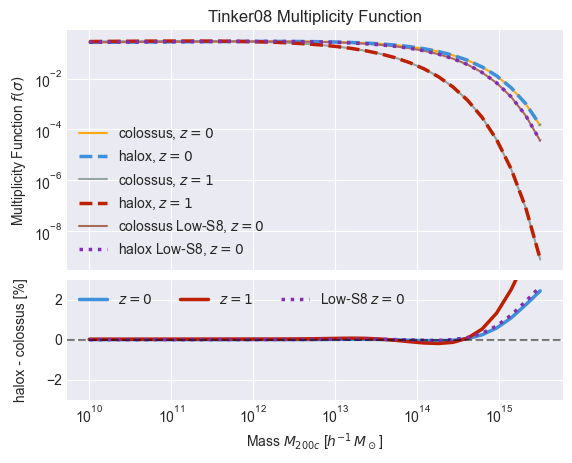

In [56]:
# Mass range and redshifts
masses = jnp.logspace(10, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# JIT-compiled functions for f(sigma) computation
halox_compute_f_sigma = jax.jit(hmf.tinker08_f_sigma)

# Compute f(sigma) for both redshifts and cosmologies
f_sigma_halox_planck = {}
f_sigma_halox_alt = {}
f_sigma_colossus_planck = {}
f_sigma_colossus_alt = {}

for z in redshifts:
    # Planck cosmology
    f_sigma_halox_planck[z] = halox_compute_f_sigma(
        masses, z, cosmo_halox_planck, delta_c
    )
    cc.setCosmology(cosmo_colossus_planck)
    f_sigma_colossus_planck[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="f",
    )

    # Alternative cosmology
    f_sigma_halox_alt[z] = halox_compute_f_sigma(
        masses, z, cosmo_halox_alt, delta_c
    )
    cc.setCosmology(cosmo_colossus_alt)
    f_sigma_colossus_alt[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="f",
    )

# Reset to Planck cosmology
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses,
    f_sigma_colossus_planck[0.0],
    label="colossus, $z=0$",
    **style_kw[0],
)
ax_main.loglog(
    masses, f_sigma_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses,
    f_sigma_colossus_planck[1.0],
    label="colossus, $z=1$",
    **style_kw[2],
)
ax_main.loglog(
    masses, f_sigma_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    f_sigma_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, f_sigma_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(r"Multiplicity Function $f(\sigma)$")
ax_main.set_title("Tinker08 Multiplicity Function")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    f_sigma_halox_planck[0.0] / f_sigma_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    f_sigma_halox_planck[1.0] / f_sigma_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (f_sigma_halox_alt[0.0] / f_sigma_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-3, 3)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### Tinker08 Mass Function dn/d ln M

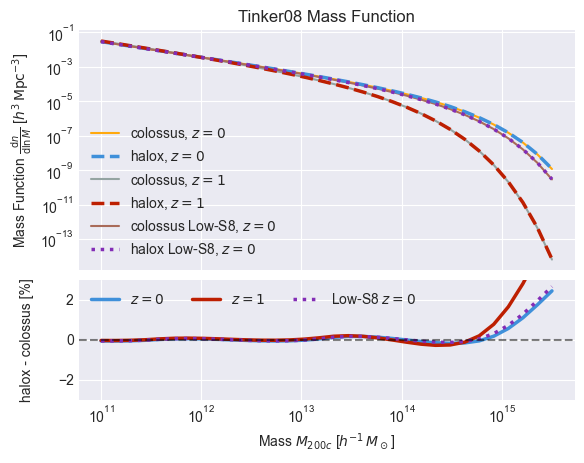

In [57]:
# Mass range and redshifts
masses = jnp.logspace(11, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# JIT-compiled function for mass function computation
halox_compute_hmf = jax.jit(hmf.tinker08_mass_function)

# Compute mass functions for both redshifts and cosmologies
dn_dlnM_halox_planck = {}
dn_dlnM_halox_alt = {}
dn_dlnM_colossus_planck = {}
dn_dlnM_colossus_alt = {}

for z in redshifts:
    # Planck cosmology
    dn_dlnM_halox_planck[z] = halox_compute_hmf(
        masses, z, cosmo_halox_planck, delta_c
    )
    cc.setCosmology(cosmo_colossus_planck)
    dn_dlnM_colossus_planck[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="dndlnM",
    )

    # Alternative cosmology
    dn_dlnM_halox_alt[z] = halox_compute_hmf(
        masses, z, cosmo_halox_alt, delta_c
    )
    cc.setCosmology(cosmo_colossus_alt)
    dn_dlnM_colossus_alt[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="dndlnM",
    )

# Reset to Planck cosmology
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses,
    dn_dlnM_colossus_planck[0.0],
    label="colossus, $z=0$",
    **style_kw[0],
)
ax_main.loglog(
    masses, dn_dlnM_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses,
    dn_dlnM_colossus_planck[1.0],
    label="colossus, $z=1$",
    **style_kw[2],
)
ax_main.loglog(
    masses, dn_dlnM_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    dn_dlnM_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, dn_dlnM_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(
    r"Mass Function $\frac{{\rm d}n}{{\rm d}\ln M}$ [$h^3 \, {\rm Mpc}^{-3}$]"
)
ax_main.set_title("Tinker08 Mass Function")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    dn_dlnM_halox_planck[0.0] / dn_dlnM_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    dn_dlnM_halox_planck[1.0] / dn_dlnM_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (dn_dlnM_halox_alt[0.0] / dn_dlnM_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-3, 3)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### Tinker10 Halo Bias

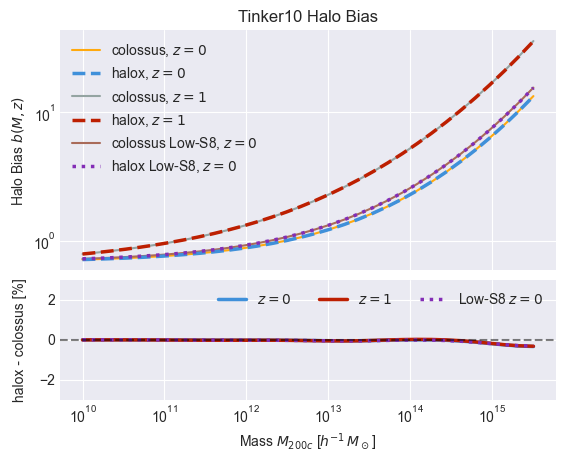

In [58]:
# Mass range and redshifts
masses = jnp.logspace(10, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# JIT-compiled function for halo bias computation
halox_compute_bias = jax.jit(bias.tinker10_bias)

# Compute halo bias for both redshifts and cosmologies
bias_halox_planck = {}
bias_halox_alt = {}
bias_colossus_planck = {}
bias_colossus_alt = {}

for z in redshifts:
    # Planck cosmology
    bias_halox_planck[z] = halox_compute_bias(
        masses, z, cosmo_halox_planck, delta_c
    )
    cc.setCosmology(cosmo_colossus_planck)
    bias_colossus_planck[z] = colossus_bias.haloBias(
        masses, z, mdef=f"{delta_c:.0f}c", model="tinker10"
    )

    # Alternative cosmology
    bias_halox_alt[z] = halox_compute_bias(masses, z, cosmo_halox_alt, delta_c)
    cc.setCosmology(cosmo_colossus_alt)
    bias_colossus_alt[z] = colossus_bias.haloBias(
        masses, z, mdef=f"{delta_c:.0f}c", model="tinker10"
    )

# Reset to Planck cosmology
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses, bias_colossus_planck[0.0], label="colossus, $z=0$", **style_kw[0]
)
ax_main.loglog(
    masses, bias_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses, bias_colossus_planck[1.0], label="colossus, $z=1$", **style_kw[2]
)
ax_main.loglog(
    masses, bias_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    bias_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, bias_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(r"Halo Bias $b(M,z)$")
ax_main.set_title("Tinker10 Halo Bias")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    bias_halox_planck[0.0] / bias_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    bias_halox_planck[1.0] / bias_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (bias_halox_alt[0.0] / bias_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-3, 3)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])